<a href="https://colab.research.google.com/github/ArmandOvanessians/Disorder/blob/main/T14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import h5py
import torch
import pandas as pd
import numpy as np

In [2]:
import h5py
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, h5_file_path, df, class_col='Class'):
        """
        Initializes the dataset by creating a list of embeddings and class labels from the HDF5 file and DataFrame.

        Parameters:
        - h5_file_path: Path to the HDF5 file containing protein embeddings.
        - df: DataFrame containing protein IDs and class labels.
        - class_col: Column name for the label. Defaults to 'Class'.
        """
        self.data = []

        # Load the HDF5 file
        with h5py.File(h5_file_path, "r") as h5_file:
            # Filter protein IDs to include only those present in the DataFrame's "ID" column
            valid_protein_ids = set(df['ID']).intersection(h5_file.keys())

            # Loop through the valid protein IDs
            for protein_id in valid_protein_ids:
                embedding = h5_file[protein_id][()]  # Load the numpy array for each protein
                embedding_tensor = torch.tensor(embedding, dtype=torch.float)  # Convert to a PyTorch tensor

                # Get the class label from the DataFrame
                label = torch.tensor(df.loc[df['ID'] == protein_id, class_col].values[0], dtype=torch.float)

                # Append the embedding, label, and protein ID as a dictionary
                self.data.append({'embedding': embedding_tensor, 'label': label, 'ID': protein_id})

    def __len__(self):
        # Return the number of embeddings
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single embedding and its label
        data = self.data[idx]
        return data['embedding'], data['label'], data['ID']


from torch.utils.data import Dataset

class CombinedSequenceDataset(Dataset):
    def __init__(self, *datasets):
        """
        Combines multiple datasets into one.

        Parameters:
        - datasets: List of SequenceDataset instances to be combined.
        """
        self.data = []

        # Append data from each dataset
        for dataset in datasets:
            self.data.extend(dataset.data)

    def __len__(self):
        # Return the total number of items across all datasets
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve a single embedding, label, and ID
        data = self.data[idx]
        return data['embedding'], data['label'], data['ID']



In [6]:
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 128, 128], dropout=0.3):
        super(MLPBinaryClassifier, self).__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.LayerNorm(dim))  # Use LayerNorm for stability
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
class ResidualMLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_blocks=4, dropout=0.3):
        super(ResidualMLPBinaryClassifier, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Residual blocks with consistent dimensions
        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ) for _ in range(num_blocks)
        ])

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.residual_blocks:
            x = block(x) + x  # Residual connection within each block
        return self.output_layer(x)

class EnhancedCNNMLPBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], conv_out_channels=32, kernel_size=3, dropout=0.5):
        super(EnhancedCNNMLPBinaryClassifier, self).__init__()

        # Define Conv1D layers with Batch Normalization and Dropout
        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=conv_out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(conv_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            nn.Conv1d(in_channels=conv_out_channels, out_channels=conv_out_channels * 2, kernel_size=kernel_size),
            nn.BatchNorm1d(conv_out_channels * 2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout)
        )

        # Calculate the flattened dimension after Conv1D and pooling
        conv1_output_dim = input_dim - (kernel_size - 1)
        pooled1_output_dim = conv1_output_dim // 2
        conv2_output_dim = pooled1_output_dim - (kernel_size - 1)
        pooled2_output_dim = conv2_output_dim // 2
        self.flattened_dim = pooled2_output_dim * conv_out_channels * 2

        # Define MLP layers with Batch Normalization and Dropout
        self.mlp_layers = nn.Sequential(
            nn.Linear(self.flattened_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[1], 1)  # Output raw score
        )

        # Sigmoid layer to constrain output between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for Conv1D
        x = self.conv1d(x)
        x = x.view(x.size(0), -1)  # Flatten for MLP
        x = self.mlp_layers(x)
        return self.sigmoid(x)  # Apply Sigmoid to output for BCELoss

In [5]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
def save_fold_data(fold, train_indices, train_ids, val_indices, val_ids):
    """Save training and validation data (both indices and IDs) for each fold."""
    fold_data = {
        'train_indices': train_indices,
        'train_ids': train_ids,
        'val_indices': val_indices,
        'val_ids': val_ids
    }
    with open(f"fold_{fold + 1}_data.pkl", "wb") as file:
        pickle.dump(fold_data, file)
    print(f"Training and validation data (indices and IDs) for Fold {fold + 1} saved.")

def benchmark_models(dataset, df, device, model_classes, num_epochs=10, batch_size=32,
                    learning_rate=1e-4, hidden_dim=64, pos_weight=1.0, neg_weight=1.0,
                    k_folds=5, augment_minority_class=False, weight_decay=0.0,
                    patience=10, save_directory='saved_models'):

    # Ensure the save directory exists
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        print(f"Created directory for saving models: {save_directory}")

    first_sequence, _, _ = dataset[0]
    input_dim = first_sequence.shape[-1]

    gene_to_indices = {}
    for idx, (_, _, gene_id) in enumerate(dataset):
        gene_name = gene_id.split("-")[0]
        if gene_name not in gene_to_indices:
            gene_to_indices[gene_name] = []
        gene_to_indices[gene_name].append(idx)

    gene_classes = []
    for gene_name, indices in gene_to_indices.items():
        gene_ids = [dataset[i][2] for i in indices]
        class_labels = df[df['ID'].isin(gene_ids)]['Class']
        majority_class = class_labels.mode()[0]
        gene_classes.append((gene_name, majority_class))

    gene_names, gene_labels = zip(*gene_classes)

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    all_results = {}

    for model_class in model_classes:
        print(f"\n=== Benchmarking Model: {model_class.__name__} ===\n")
        results = []
        best_val_accuracy = 0.0
        best_model_state = None

        for fold, (train_gene_idxs, val_gene_idxs) in enumerate(skf.split(gene_names, gene_labels)):
            print(f"\nFOLD {fold + 1}/{k_folds}")

            train_genes = [gene_names[i] for i in train_gene_idxs]
            val_genes = [gene_names[i] for i in val_gene_idxs]

            train_indices = [idx for gene in train_genes for idx in gene_to_indices[gene]]
            val_indices = [idx for gene in val_genes for idx in gene_to_indices[gene]]

            train_ids = [dataset[idx][2] for idx in train_indices]
            val_ids = [dataset[idx][2] for idx in val_indices]

            save_fold_data(fold, train_indices, train_ids, val_indices, val_ids)

            train_subset = Subset(dataset, train_indices)
            val_subset = Subset(dataset, val_indices)

            # Initialize each model with appropriate parameters
            if model_class.__name__ == "MLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dims=[128, 64, 32], dropout=0.4).to(device)
            elif model_class.__name__ == "AdvancedCNNBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    conv_out_channels=64,
                    hidden_dims=[128, 64],
                    dropout=0.3
                ).to(device)
            elif model_class.__name__ == "ResidualMLPBinaryClassifier":
                model = model_class(input_dim=input_dim, hidden_dim=128, dropout=0.4).to(device)
            elif model_class.__name__ == "EnhancedCNNMLPBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dims=[128, 64],
                    conv_out_channels=32,
                    kernel_size=3,
                    dropout=0.4
                ).to(device)
            elif model_class.__name__ == "TransformerBinaryClassifier":
                model = model_class(
                    input_dim=input_dim,
                    hidden_dim=hidden_dim,
                    nhead=4,
                    num_layers=2,
                    dropout=0.1
                ).to(device)
            else:
                raise ValueError(f"Unknown model class: {model_class.__name__}")

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

            criterion = nn.BCELoss(reduction='none')
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            best_val_loss = float('inf')
            epochs_without_improvement = 0

            train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

            for epoch in range(num_epochs):
                model.train()
                train_loss, correct_train, total_train = 0, 0, 0

                for batch in train_loader:
                    sequences, labels, _ = batch
                    sequences, labels = sequences.to(device), labels.to(device)

                    weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                    logits = model(sequences).squeeze(dim=1)
                    loss_per_sample = criterion(logits, labels.float())
                    loss = (loss_per_sample * weight).mean()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item() * sequences.size(0)
                    preds = (logits > 0.5).float()
                    correct_train += (preds == labels).sum().item()
                    total_train += labels.size(0)

                train_losses.append(train_loss / total_train)
                train_accuracies.append(correct_train / total_train)

                model.eval()
                val_loss, correct_val, total_val = 0, 0, 0
                val_labels, val_preds, val_logits = [], [], []

                with torch.no_grad():
                    for batch in val_loader:
                        sequences, labels, _ = batch
                        sequences, labels = sequences.to(device), labels.to(device)

                        logits = model(sequences).squeeze()
                        loss_per_sample = criterion(logits.view(-1), labels.float().view(-1))
                        weight = torch.where(labels == 1, pos_weight, neg_weight).to(device)
                        val_loss += (loss_per_sample * weight).mean().item() * sequences.size(0)

                        predictions = (logits > 0.5).float()

                        if predictions.dim() == 0:
                            predictions = predictions.unsqueeze(0)  # Ensure predictions is 1-dimensional

                        correct_val += (predictions == labels).sum().item()
                        total_val += labels.size(0)

                        # Convert tensors to lists or handle scalars before extending
                        val_labels.extend(labels.cpu().numpy())
                        val_preds.extend(predictions.cpu().numpy().tolist())

                        # Handle logits being a scalar
                        val_logits.extend(logits.cpu().numpy().tolist() if logits.dim() > 0 else [logits.cpu().item()])

                val_losses.append(val_loss / total_val)
                val_accuracies.append(correct_val / total_val)

                print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1

                if epochs_without_improvement >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs.")
                    break

            # After training, save the best model weights for this fold
            model_filename = f"{model_class.__name__}_fold{fold + 1}_weights.pth"
            model_path = os.path.join(save_directory, model_filename)
            torch.save(best_model_state, model_path)
            print(f"Saved model weights for {model_class.__name__} Fold {fold + 1} at {model_path}")

            precision = precision_score(val_labels, val_preds, zero_division=0)
            recall = recall_score(val_labels, val_preds)
            f1 = f1_score(val_labels, val_preds)
            auc_roc = roc_auc_score(val_labels, val_logits)

            print(f"Fold {fold + 1} Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")

            cm = confusion_matrix(val_labels, val_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
            disp.plot(cmap="Blues")
            plt.title(f'Confusion Matrix - Fold {fold + 1} - Model: {model_class.__name__}')
            plt.show()

            results.append({
                'Fold': fold + 1,
                'Validation Accuracy': val_accuracies[-1],
                'Validation Loss': val_losses[-1],
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'AUC-ROC': auc_roc
            })

        avg_accuracy = sum(result['Validation Accuracy'] for result in results) / k_folds
        avg_precision = sum(result['Precision'] for result in results) / k_folds
        avg_recall = sum(result['Recall'] for result in results) / k_folds
        avg_f1 = sum(result['F1 Score'] for result in results) / k_folds
        avg_auc_roc = sum(result['AUC-ROC'] for result in results) / k_folds

        print(f"\nModel: {model_class.__name__} - Average Validation Accuracy: {avg_accuracy:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print(f"Average AUC-ROC: {avg_auc_roc:.4f}")

        all_results[model_class.__name__] = {
            'Avg Validation Accuracy': avg_accuracy,
            'Avg Precision': avg_precision,
            'Avg Recall': avg_recall,
            'Avg F1 Score': avg_f1,
            'Avg AUC-ROC': avg_auc_roc
        }

    return all_results


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
data_rep = 'per_protein_embeddings_repression.h5'
data_act = 'per_protein_embeddings_activation_bintu.h5'
data_Bintu = 'BINTU_FULL.csv'
df_Bintu = pd.read_csv(data_Bintu)
df_Bintu = df_Bintu.drop(df_Bintu.columns[0], axis=1)
d_act = SequenceDataset(h5_file_path=data_act, df=df_Bintu)
d_rep = SequenceDataset(h5_file_path=data_rep, df=df_Bintu)
# Combine d_act and d_rep
combined_dataset = CombinedSequenceDataset(d_rep, d_act)

Load in Bintu

Created directory for saving models: saved_models

=== Benchmarking Model: MLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Epoch [1/100], Train Loss: 0.3508, Val Loss: 0.2468, Train Acc: 0.8771, Val Acc: 0.9048
Epoch [2/100], Train Loss: 0.2727, Val Loss: 0.2274, Train Acc: 0.8983, Val Acc: 0.9151
Epoch [3/100], Train Loss: 0.2525, Val Loss: 0.2105, Train Acc: 0.9101, Val Acc: 0.9110
Epoch [4/100], Train Loss: 0.2494, Val Loss: 0.2214, Train Acc: 0.9007, Val Acc: 0.9213
Epoch [5/100], Train Loss: 0.2216, Val Loss: 0.2106, Train Acc: 0.9115, Val Acc: 0.9151
Epoch [6/100], Train Loss: 0.2125, Val Loss: 0.2271, Train Acc: 0.9155, Val Acc: 0.9048
Epoch [7/100], Train Loss: 0.2130, Val Loss: 0.2204, Train Acc: 0.9135, Val Acc: 0.9130
Epoch [8/100], Train Loss: 0.2066, Val Loss: 0.2284, Train Acc: 0.9209, Val Acc: 0.9172
Epoch [9/100], Train Loss: 0.1898, Val Loss: 0.2106, Train Acc: 0.9268, Val Acc: 0.9234
Epoch [10/100], Train Loss: 0.200

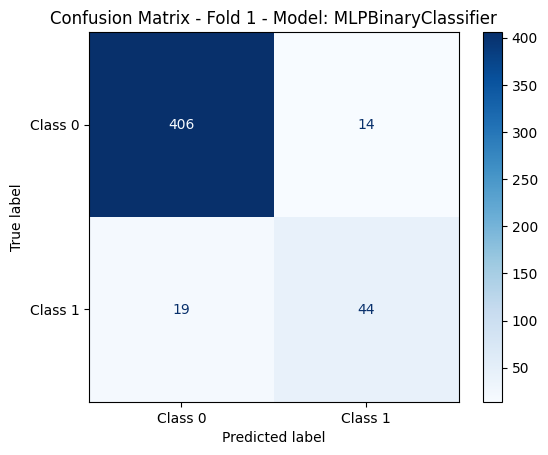


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Epoch [1/100], Train Loss: 0.3655, Val Loss: 0.3326, Train Acc: 0.8757, Val Acc: 0.8774
Epoch [2/100], Train Loss: 0.2633, Val Loss: 0.3128, Train Acc: 0.9082, Val Acc: 0.8852
Epoch [3/100], Train Loss: 0.2404, Val Loss: 0.3428, Train Acc: 0.9117, Val Acc: 0.8891
Epoch [4/100], Train Loss: 0.2362, Val Loss: 0.3195, Train Acc: 0.9182, Val Acc: 0.8813
Epoch [5/100], Train Loss: 0.2269, Val Loss: 0.2643, Train Acc: 0.9172, Val Acc: 0.8911
Epoch [6/100], Train Loss: 0.2092, Val Loss: 0.2836, Train Acc: 0.9177, Val Acc: 0.8813
Epoch [7/100], Train Loss: 0.2054, Val Loss: 0.3148, Train Acc: 0.9162, Val Acc: 0.8852
Epoch [8/100], Train Loss: 0.2132, Val Loss: 0.2826, Train Acc: 0.9187, Val Acc: 0.8949
Epoch [9/100], Train Loss: 0.1952, Val Loss: 0.3352, Train Acc: 0.9167, Val Acc: 0.8930
Epoch [10/100], Train Loss: 0.1868, Val Loss: 0.3345, Train Acc: 0.9261, Val Acc: 0.8833
Epoch [11/100], Train Loss: 0.1912, Val Loss

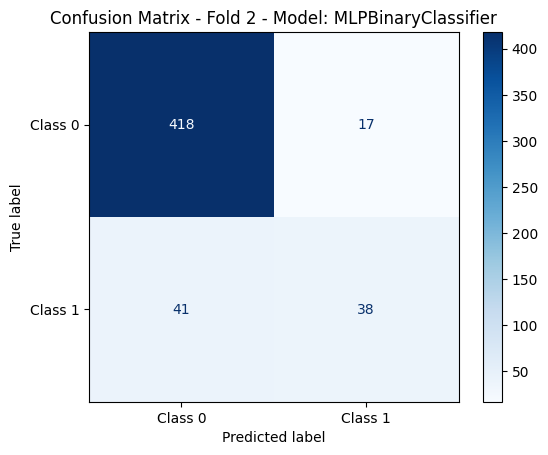


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Epoch [1/100], Train Loss: 0.3947, Val Loss: 0.2540, Train Acc: 0.8606, Val Acc: 0.9155
Epoch [2/100], Train Loss: 0.2774, Val Loss: 0.2115, Train Acc: 0.8905, Val Acc: 0.9234
Epoch [3/100], Train Loss: 0.2570, Val Loss: 0.2727, Train Acc: 0.8980, Val Acc: 0.8546
Epoch [4/100], Train Loss: 0.2371, Val Loss: 0.2278, Train Acc: 0.9109, Val Acc: 0.8978
Epoch [5/100], Train Loss: 0.2333, Val Loss: 0.2166, Train Acc: 0.9009, Val Acc: 0.9136
Epoch [6/100], Train Loss: 0.2236, Val Loss: 0.2131, Train Acc: 0.9139, Val Acc: 0.9234
Epoch [7/100], Train Loss: 0.2197, Val Loss: 0.1992, Train Acc: 0.9154, Val Acc: 0.9253
Epoch [8/100], Train Loss: 0.2027, Val Loss: 0.2105, Train Acc: 0.9263, Val Acc: 0.8998
Epoch [9/100], Train Loss: 0.1994, Val Loss: 0.2352, Train Acc: 0.9204, Val Acc: 0.8998
Epoch [10/100], Train Loss: 0.1966, Val Loss: 0.2316, Train Acc: 0.9169, Val Acc: 0.8998
Epoch [11/100], Train Loss: 0.1968, Val Loss

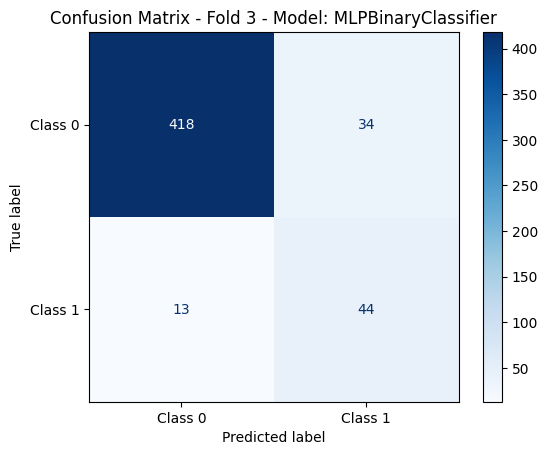


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Epoch [1/100], Train Loss: 0.3656, Val Loss: 0.2365, Train Acc: 0.8780, Val Acc: 0.9209
Epoch [2/100], Train Loss: 0.2786, Val Loss: 0.1959, Train Acc: 0.8943, Val Acc: 0.9270
Epoch [3/100], Train Loss: 0.2536, Val Loss: 0.2053, Train Acc: 0.9047, Val Acc: 0.9249
Epoch [4/100], Train Loss: 0.2460, Val Loss: 0.1983, Train Acc: 0.9052, Val Acc: 0.9310
Epoch [5/100], Train Loss: 0.2428, Val Loss: 0.1863, Train Acc: 0.9042, Val Acc: 0.9270
Epoch [6/100], Train Loss: 0.2296, Val Loss: 0.1806, Train Acc: 0.9136, Val Acc: 0.9209
Epoch [7/100], Train Loss: 0.2125, Val Loss: 0.1736, Train Acc: 0.9146, Val Acc: 0.9351
Epoch [8/100], Train Loss: 0.2114, Val Loss: 0.1725, Train Acc: 0.9210, Val Acc: 0.9371
Epoch [9/100], Train Loss: 0.2105, Val Loss: 0.1882, Train Acc: 0.9170, Val Acc: 0.9209
Epoch [10/100], Train Loss: 0.2138, Val Loss: 0.1834, Train Acc: 0.9151, Val Acc: 0.9290
Epoch [11/100], Train Loss: 0.1993, Val Loss

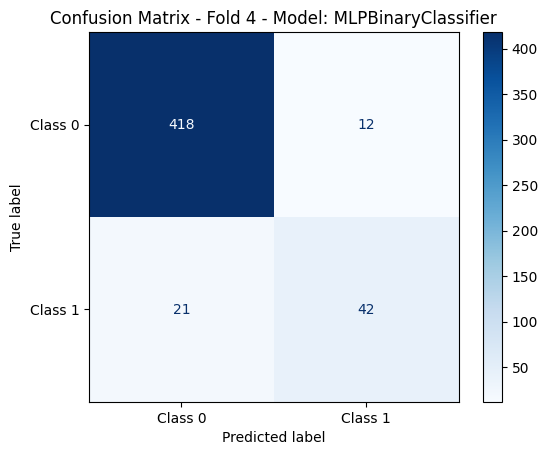


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Epoch [1/100], Train Loss: 0.3785, Val Loss: 0.2466, Train Acc: 0.8684, Val Acc: 0.9114
Epoch [2/100], Train Loss: 0.2769, Val Loss: 0.2272, Train Acc: 0.8969, Val Acc: 0.9229
Epoch [3/100], Train Loss: 0.2563, Val Loss: 0.2339, Train Acc: 0.9040, Val Acc: 0.8960
Epoch [4/100], Train Loss: 0.2440, Val Loss: 0.2346, Train Acc: 0.9085, Val Acc: 0.8940
Epoch [5/100], Train Loss: 0.2212, Val Loss: 0.2135, Train Acc: 0.9150, Val Acc: 0.9171
Epoch [6/100], Train Loss: 0.2192, Val Loss: 0.2663, Train Acc: 0.9140, Val Acc: 0.8593
Epoch [7/100], Train Loss: 0.2170, Val Loss: 0.2534, Train Acc: 0.9160, Val Acc: 0.8767
Epoch [8/100], Train Loss: 0.2153, Val Loss: 0.2309, Train Acc: 0.9115, Val Acc: 0.8979
Epoch [9/100], Train Loss: 0.2078, Val Loss: 0.2155, Train Acc: 0.9250, Val Acc: 0.9133
Epoch [10/100], Train Loss: 0.2010, Val Loss: 0.2259, Train Acc: 0.9230, Val Acc: 0.8960
Epoch [11/100], Train Loss: 0.1940, Val Loss

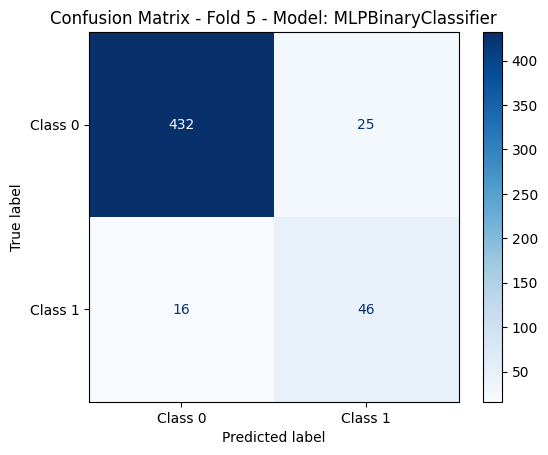


Model: MLPBinaryClassifier - Average Validation Accuracy: 0.9161
Average Precision: 0.6879
Average Recall: 0.6720
Average F1 Score: 0.6712
Average AUC-ROC: 0.9199

=== Benchmarking Model: ResidualMLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Epoch [1/100], Train Loss: 0.3077, Val Loss: 0.2192, Train Acc: 0.8791, Val Acc: 0.9089
Epoch [2/100], Train Loss: 0.2198, Val Loss: 0.2246, Train Acc: 0.9120, Val Acc: 0.9172
Epoch [3/100], Train Loss: 0.2156, Val Loss: 0.2048, Train Acc: 0.9174, Val Acc: 0.9130
Epoch [4/100], Train Loss: 0.2025, Val Loss: 0.2133, Train Acc: 0.9179, Val Acc: 0.9193
Epoch [5/100], Train Loss: 0.1869, Val Loss: 0.2260, Train Acc: 0.9214, Val Acc: 0.9089
Epoch [6/100], Train Loss: 0.1834, Val Loss: 0.2100, Train Acc: 0.9209, Val Acc: 0.9213
Epoch [7/100], Train Loss: 0.1736, Val Loss: 0.1975, Train Acc: 0.9327, Val Acc: 0.9213
Epoch [8/100], Train Loss: 0.1692, Val Loss: 0.1977, Train Acc: 0.9307, Val Acc: 0.9275

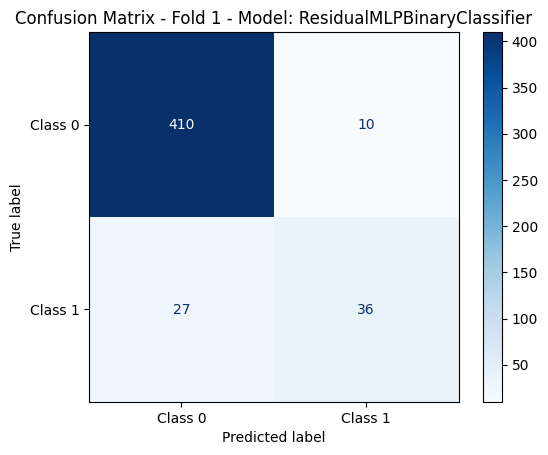


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Epoch [1/100], Train Loss: 0.3073, Val Loss: 0.2676, Train Acc: 0.8817, Val Acc: 0.8833
Epoch [2/100], Train Loss: 0.2121, Val Loss: 0.2853, Train Acc: 0.9137, Val Acc: 0.8872
Epoch [3/100], Train Loss: 0.2075, Val Loss: 0.2917, Train Acc: 0.9142, Val Acc: 0.8852
Epoch [4/100], Train Loss: 0.1839, Val Loss: 0.2750, Train Acc: 0.9222, Val Acc: 0.8949
Epoch [5/100], Train Loss: 0.1842, Val Loss: 0.2474, Train Acc: 0.9212, Val Acc: 0.8891
Epoch [6/100], Train Loss: 0.1674, Val Loss: 0.3154, Train Acc: 0.9291, Val Acc: 0.8969
Epoch [7/100], Train Loss: 0.1671, Val Loss: 0.2706, Train Acc: 0.9311, Val Acc: 0.8911
Epoch [8/100], Train Loss: 0.1532, Val Loss: 0.2881, Train Acc: 0.9386, Val Acc: 0.9008
Epoch [9/100], Train Loss: 0.1492, Val Loss: 0.3144, Train Acc: 0.9381, Val Acc: 0.8949
Epoch [10/100], Train Loss: 0.1510, Val Loss: 0.3186, Train Acc: 0.9366, Val Acc: 0.8949
Epoch [11/100], Train Loss: 0.1357, Val Loss

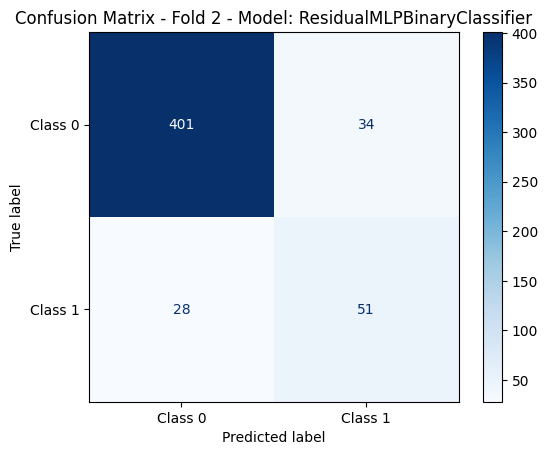


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Epoch [1/100], Train Loss: 0.3128, Val Loss: 0.2165, Train Acc: 0.8805, Val Acc: 0.9175
Epoch [2/100], Train Loss: 0.2295, Val Loss: 0.2140, Train Acc: 0.9029, Val Acc: 0.9214
Epoch [3/100], Train Loss: 0.2019, Val Loss: 0.2124, Train Acc: 0.9154, Val Acc: 0.9194
Epoch [4/100], Train Loss: 0.1855, Val Loss: 0.2136, Train Acc: 0.9233, Val Acc: 0.9136
Epoch [5/100], Train Loss: 0.1859, Val Loss: 0.2184, Train Acc: 0.9194, Val Acc: 0.9175
Epoch [6/100], Train Loss: 0.1735, Val Loss: 0.2254, Train Acc: 0.9323, Val Acc: 0.9136
Epoch [7/100], Train Loss: 0.1762, Val Loss: 0.2223, Train Acc: 0.9273, Val Acc: 0.9214
Epoch [8/100], Train Loss: 0.1722, Val Loss: 0.2113, Train Acc: 0.9238, Val Acc: 0.9175
Epoch [9/100], Train Loss: 0.1662, Val Loss: 0.2259, Train Acc: 0.9283, Val Acc: 0.9214
Epoch [10/100], Train Loss: 0.1522, Val Loss: 0.2138, Train Acc: 0.9343, Val Acc: 0.9194
Epoch [11/100], Train Loss: 0.1582, Val Loss

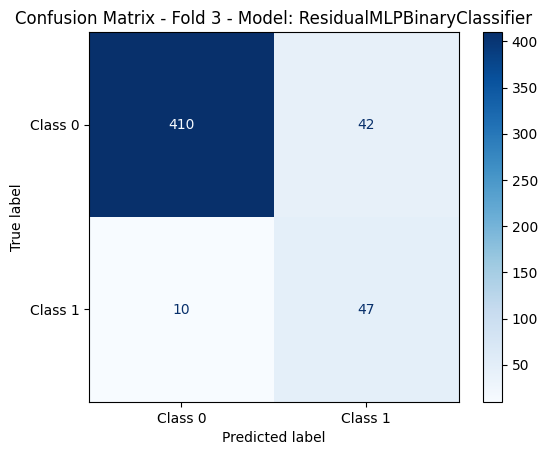


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Epoch [1/100], Train Loss: 0.3184, Val Loss: 0.1882, Train Acc: 0.8800, Val Acc: 0.9290
Epoch [2/100], Train Loss: 0.2421, Val Loss: 0.1771, Train Acc: 0.9017, Val Acc: 0.9290
Epoch [3/100], Train Loss: 0.2182, Val Loss: 0.1742, Train Acc: 0.9111, Val Acc: 0.9310
Epoch [4/100], Train Loss: 0.2045, Val Loss: 0.1700, Train Acc: 0.9151, Val Acc: 0.9351
Epoch [5/100], Train Loss: 0.1926, Val Loss: 0.1883, Train Acc: 0.9170, Val Acc: 0.9310
Epoch [6/100], Train Loss: 0.1927, Val Loss: 0.1730, Train Acc: 0.9160, Val Acc: 0.9331
Epoch [7/100], Train Loss: 0.1739, Val Loss: 0.1859, Train Acc: 0.9323, Val Acc: 0.9249
Epoch [8/100], Train Loss: 0.1787, Val Loss: 0.1936, Train Acc: 0.9254, Val Acc: 0.9108
Epoch [9/100], Train Loss: 0.1667, Val Loss: 0.1731, Train Acc: 0.9304, Val Acc: 0.9391
Epoch [10/100], Train Loss: 0.1666, Val Loss: 0.1898, Train Acc: 0.9314, Val Acc: 0.9310
Epoch [11/100], Train Loss: 0.1530, Val Loss

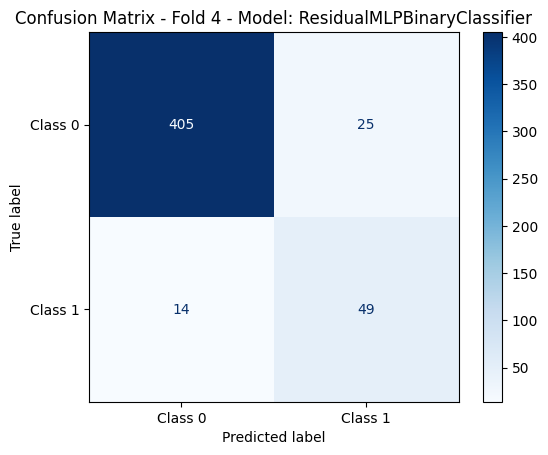


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Epoch [1/100], Train Loss: 0.3135, Val Loss: 0.2337, Train Acc: 0.8839, Val Acc: 0.9094
Epoch [2/100], Train Loss: 0.2297, Val Loss: 0.2127, Train Acc: 0.9075, Val Acc: 0.9133
Epoch [3/100], Train Loss: 0.2063, Val Loss: 0.2429, Train Acc: 0.9140, Val Acc: 0.8902
Epoch [4/100], Train Loss: 0.2049, Val Loss: 0.2343, Train Acc: 0.9215, Val Acc: 0.9075
Epoch [5/100], Train Loss: 0.1846, Val Loss: 0.2131, Train Acc: 0.9250, Val Acc: 0.9171
Epoch [6/100], Train Loss: 0.1746, Val Loss: 0.2126, Train Acc: 0.9325, Val Acc: 0.9152
Epoch [7/100], Train Loss: 0.1710, Val Loss: 0.2218, Train Acc: 0.9280, Val Acc: 0.9171
Epoch [8/100], Train Loss: 0.1588, Val Loss: 0.2295, Train Acc: 0.9280, Val Acc: 0.9210
Epoch [9/100], Train Loss: 0.1660, Val Loss: 0.2067, Train Acc: 0.9300, Val Acc: 0.9287
Epoch [10/100], Train Loss: 0.1443, Val Loss: 0.2349, Train Acc: 0.9395, Val Acc: 0.9152
Epoch [11/100], Train Loss: 0.1431, Val Loss

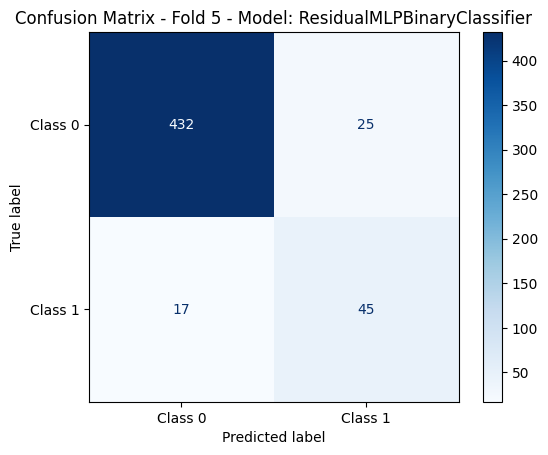


Model: ResidualMLPBinaryClassifier - Average Validation Accuracy: 0.9081
Average Precision: 0.6431
Average Recall: 0.7090
Average F1 Score: 0.6647
Average AUC-ROC: 0.9217

=== Benchmarking Model: EnhancedCNNMLPBinaryClassifier ===


FOLD 1/5
Training and validation data (indices and IDs) for Fold 1 saved.
Epoch [1/100], Train Loss: 0.4188, Val Loss: 0.2955, Train Acc: 0.8354, Val Acc: 0.9213
Epoch [2/100], Train Loss: 0.2692, Val Loss: 0.2264, Train Acc: 0.8929, Val Acc: 0.9213
Epoch [3/100], Train Loss: 0.2424, Val Loss: 0.2202, Train Acc: 0.9052, Val Acc: 0.9255
Epoch [4/100], Train Loss: 0.2201, Val Loss: 0.2163, Train Acc: 0.9076, Val Acc: 0.9151
Epoch [5/100], Train Loss: 0.2163, Val Loss: 0.2164, Train Acc: 0.9160, Val Acc: 0.9255
Epoch [6/100], Train Loss: 0.2086, Val Loss: 0.2129, Train Acc: 0.9081, Val Acc: 0.9234
Epoch [7/100], Train Loss: 0.1989, Val Loss: 0.2155, Train Acc: 0.9194, Val Acc: 0.9275
Epoch [8/100], Train Loss: 0.1820, Val Loss: 0.1989, Train Acc: 0.9204, Val 

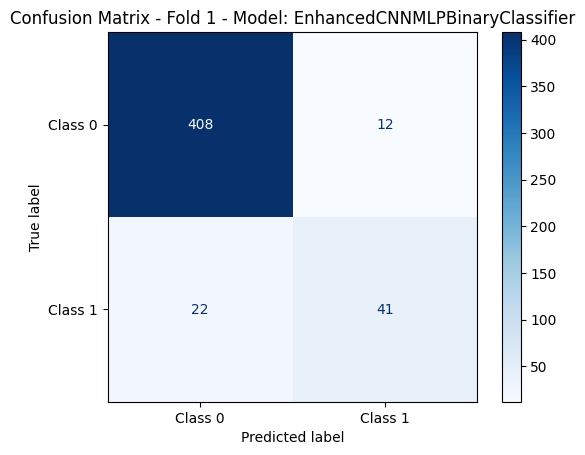


FOLD 2/5
Training and validation data (indices and IDs) for Fold 2 saved.
Epoch [1/100], Train Loss: 0.4217, Val Loss: 0.3332, Train Acc: 0.8328, Val Acc: 0.8794
Epoch [2/100], Train Loss: 0.2638, Val Loss: 0.2754, Train Acc: 0.9047, Val Acc: 0.8872
Epoch [3/100], Train Loss: 0.2337, Val Loss: 0.2675, Train Acc: 0.9077, Val Acc: 0.8833
Epoch [4/100], Train Loss: 0.2150, Val Loss: 0.2663, Train Acc: 0.9097, Val Acc: 0.8930
Epoch [5/100], Train Loss: 0.2099, Val Loss: 0.2532, Train Acc: 0.9097, Val Acc: 0.8930
Epoch [6/100], Train Loss: 0.2199, Val Loss: 0.2623, Train Acc: 0.9117, Val Acc: 0.8949
Epoch [7/100], Train Loss: 0.1880, Val Loss: 0.2579, Train Acc: 0.9222, Val Acc: 0.8969
Epoch [8/100], Train Loss: 0.1850, Val Loss: 0.2540, Train Acc: 0.9256, Val Acc: 0.8949
Epoch [9/100], Train Loss: 0.1886, Val Loss: 0.2737, Train Acc: 0.9122, Val Acc: 0.8949
Epoch [10/100], Train Loss: 0.1730, Val Loss: 0.2418, Train Acc: 0.9261, Val Acc: 0.8969
Epoch [11/100], Train Loss: 0.1804, Val Loss

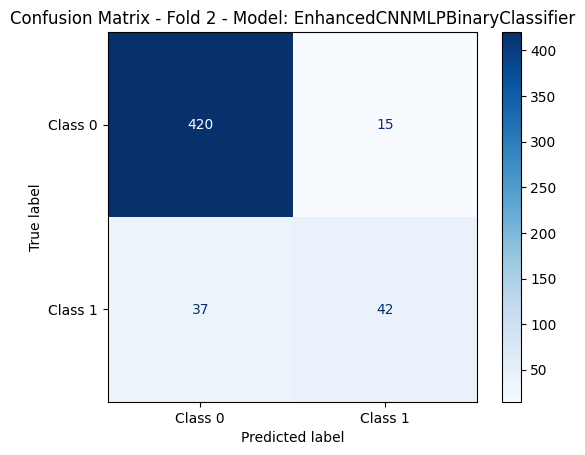


FOLD 3/5
Training and validation data (indices and IDs) for Fold 3 saved.
Epoch [1/100], Train Loss: 0.4013, Val Loss: 0.2664, Train Acc: 0.8482, Val Acc: 0.9057
Epoch [2/100], Train Loss: 0.2728, Val Loss: 0.2346, Train Acc: 0.8930, Val Acc: 0.9194
Epoch [3/100], Train Loss: 0.2420, Val Loss: 0.2228, Train Acc: 0.8990, Val Acc: 0.9136
Epoch [4/100], Train Loss: 0.2378, Val Loss: 0.2149, Train Acc: 0.9029, Val Acc: 0.9253
Epoch [5/100], Train Loss: 0.2182, Val Loss: 0.2211, Train Acc: 0.9059, Val Acc: 0.9273
Epoch [6/100], Train Loss: 0.2196, Val Loss: 0.2119, Train Acc: 0.9009, Val Acc: 0.9234
Epoch [7/100], Train Loss: 0.1964, Val Loss: 0.2184, Train Acc: 0.9129, Val Acc: 0.9253
Epoch [8/100], Train Loss: 0.1977, Val Loss: 0.2403, Train Acc: 0.9134, Val Acc: 0.9077
Epoch [9/100], Train Loss: 0.1841, Val Loss: 0.2119, Train Acc: 0.9144, Val Acc: 0.9194
Epoch [10/100], Train Loss: 0.1863, Val Loss: 0.2121, Train Acc: 0.9189, Val Acc: 0.9155
Epoch [11/100], Train Loss: 0.1819, Val Loss

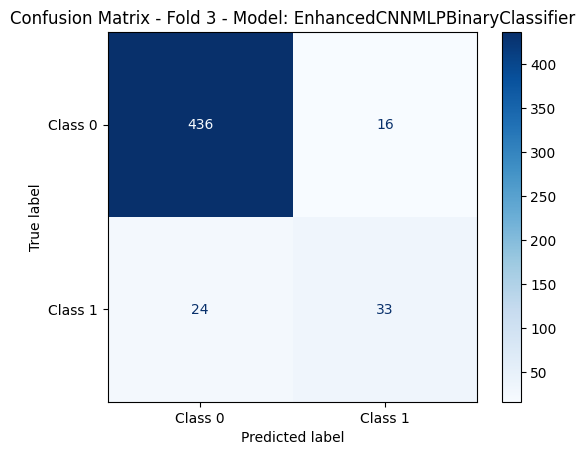


FOLD 4/5
Training and validation data (indices and IDs) for Fold 4 saved.
Epoch [1/100], Train Loss: 0.4244, Val Loss: 0.2642, Train Acc: 0.8301, Val Acc: 0.9148
Epoch [2/100], Train Loss: 0.2754, Val Loss: 0.2237, Train Acc: 0.8938, Val Acc: 0.9189
Epoch [3/100], Train Loss: 0.2433, Val Loss: 0.2205, Train Acc: 0.9002, Val Acc: 0.9209
Epoch [4/100], Train Loss: 0.2234, Val Loss: 0.2022, Train Acc: 0.9146, Val Acc: 0.9331
Epoch [5/100], Train Loss: 0.2301, Val Loss: 0.1997, Train Acc: 0.9037, Val Acc: 0.9229
Epoch [6/100], Train Loss: 0.2200, Val Loss: 0.2006, Train Acc: 0.9042, Val Acc: 0.9148
Epoch [7/100], Train Loss: 0.1993, Val Loss: 0.1838, Train Acc: 0.9121, Val Acc: 0.9290
Epoch [8/100], Train Loss: 0.1925, Val Loss: 0.1959, Train Acc: 0.9096, Val Acc: 0.9148
Epoch [9/100], Train Loss: 0.2003, Val Loss: 0.1887, Train Acc: 0.9111, Val Acc: 0.9229
Epoch [10/100], Train Loss: 0.2015, Val Loss: 0.1808, Train Acc: 0.9131, Val Acc: 0.9310
Epoch [11/100], Train Loss: 0.1851, Val Loss

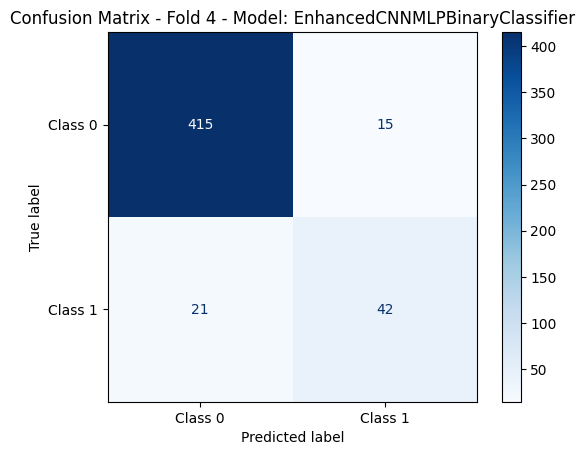


FOLD 5/5
Training and validation data (indices and IDs) for Fold 5 saved.
Epoch [1/100], Train Loss: 0.4077, Val Loss: 0.3027, Train Acc: 0.8494, Val Acc: 0.9094
Epoch [2/100], Train Loss: 0.2648, Val Loss: 0.2964, Train Acc: 0.8994, Val Acc: 0.9037
Epoch [3/100], Train Loss: 0.2366, Val Loss: 0.2274, Train Acc: 0.9110, Val Acc: 0.9152
Epoch [4/100], Train Loss: 0.2311, Val Loss: 0.2370, Train Acc: 0.9075, Val Acc: 0.9075
Epoch [5/100], Train Loss: 0.2101, Val Loss: 0.2526, Train Acc: 0.9140, Val Acc: 0.9017
Epoch [6/100], Train Loss: 0.2102, Val Loss: 0.2161, Train Acc: 0.9130, Val Acc: 0.9171
Epoch [7/100], Train Loss: 0.1892, Val Loss: 0.2252, Train Acc: 0.9190, Val Acc: 0.9075
Epoch [8/100], Train Loss: 0.1989, Val Loss: 0.2201, Train Acc: 0.9095, Val Acc: 0.9133
Epoch [9/100], Train Loss: 0.1919, Val Loss: 0.2317, Train Acc: 0.9195, Val Acc: 0.9152
Epoch [10/100], Train Loss: 0.1786, Val Loss: 0.2362, Train Acc: 0.9215, Val Acc: 0.9017
Epoch [11/100], Train Loss: 0.1882, Val Loss

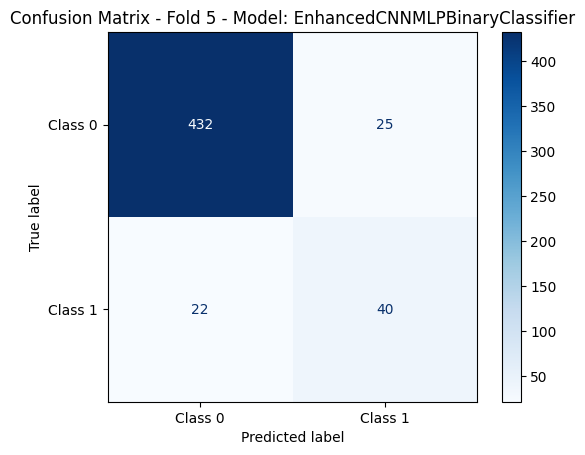


Model: EnhancedCNNMLPBinaryClassifier - Average Validation Accuracy: 0.9173
Average Precision: 0.7072
Average Recall: 0.6146
Average F1 Score: 0.6554
Average AUC-ROC: 0.9157

=== Benchmark Results ===

Model: MLPBinaryClassifier
Avg Validation Accuracy: 0.9161
Avg Precision: 0.6879
Avg Recall: 0.6720
Avg F1 Score: 0.6712
Avg AUC-ROC: 0.9199


Model: ResidualMLPBinaryClassifier
Avg Validation Accuracy: 0.9081
Avg Precision: 0.6431
Avg Recall: 0.7090
Avg F1 Score: 0.6647
Avg AUC-ROC: 0.9217


Model: EnhancedCNNMLPBinaryClassifier
Avg Validation Accuracy: 0.9173
Avg Precision: 0.7072
Avg Recall: 0.6146
Avg F1 Score: 0.6554
Avg AUC-ROC: 0.9157




In [12]:
# List of model classes to benchmark
model_classes = [
    #EnhancedCNNMLPBinaryClassifier,
    MLPBinaryClassifier,
    ResidualMLPBinaryClassifier,
    EnhancedCNNMLPBinaryClassifier

]

# Run the benchmark on all models
results = benchmark_models(
    dataset=combined_dataset,
    df=df_Bintu,
    device=device,
    model_classes=model_classes,
    num_epochs=100,               # Use a lower number of epochs to start, increase if needed
    batch_size=16,
    learning_rate=0.001,
    hidden_dim=64,               # ForA transformer or other models needing hidden dimension
    pos_weight=1,
    neg_weight=1,
    k_folds=5,
    augment_minority_class=True, # If your dataset is imbalanced
    weight_decay=0.001,
    patience=10
)

# Displaying benchmark results
print("\n=== Benchmark Results ===\n")
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("\n" + "="*30 + "\n")